In [ ]:

# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Function Calling with the Gemini API & Python SDK

## 1. Overview

### What is function calling in Gemini?
The Vertex AI Gemini API is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. Function calling is a feature of Gemini models that makes it easier for developers to get structured data outputs from generative models.

Developers can then use these outputs to call other APIs and return the relevant response data to the model. In other words, function calling helps you connect your generative models to external systems so that the generated content includes the most up-to-date and accurate information.

### How function calling works
Functions are described using function declarations, which helps the generative model understand the purpose and parameters within a function. After you pass function declarations in a query to a generative model, the model returns a structured object that includes the names of relevant functions and their arguments based on the user's query. Note that with function calling, the model doesn't actually call the function. Instead, you can use the returned function and parameters to call the function in any language, library, or framework that you'd like!

### What you'll build
In this codelab, you'll build a generative AI pipeline with the Vertex AI Gemini API and Python. Using your app, users can ask about exchange rates, and the system will fetch the latest data from an external API and respond to the user with the answer.

### What you'll learn
How to interact with the Gemini model using the Python client library
How to define a function declaration and register it as a tool
How to call Gemini and get a function call response
How to return the function response to Gemini and respond to the user

### What you'll need
A Google Cloud Project
A browser such as Chrome
A Python development environment such as Colab or Colab Enterprise

## 2. Setup and requirements
Before you can start using function calling in Gemini, you need to enable the Vertex AI API and install the latest version of the Vertex AI Python client library.

Enable Vertex AI API
To enable the Vertex AI API, follow these steps:

In your browser, navigate to the Vertex AI API Service Details page.
Click the Enable button to enable the Vertex AI API in your Google Cloud project.
Install Python client library for Vertex AI
To install the Python client libraries for Vertex AI, follow these steps:

Open a terminal in your development environment.
Verify that you have a valid Python development environment, and refer to these guidelines if needed.


In [ ]:
#!pip install --upgrade google-cloud-aiplatform

## 3. Understand the problem
Have you ever interacted with a large language model or generative AI model and asked it about real-time or current information, only to get a response with outdated information or inaccurate information?

Let's try it now! First, we'll import the relevant Python packages and initialize the Gemini model. You can run the following code in a Python development environment such as Colab or Colab Enterprise and by installing the latest version of the Vertex AI SDK for Python:

In [4]:
import vertexai
from vertexai.generative_models import GenerativeModel

In [5]:
vertexai.init(project = "gdg-demo-rpoect")

In [6]:
model = GenerativeModel("gemini-2.0-flash-001")

In [7]:
response = model.generate_content(
    "What's the exchange rate for euros to dollars today?"
)
print(response.text)

As a large language model, I don't have access to live, real-time data like current exchange rates. Exchange rates fluctuate constantly!

To get the most accurate and up-to-the-minute EUR/USD exchange rate, I recommend checking one of these sources:

*   **Google Finance:** Just search "EUR to USD" on Google.
*   **A reputable financial website:** Examples include Bloomberg, Reuters, Yahoo Finance, or MarketWatch.
*   **Your bank or financial institution's website:** They will often have their specific exchange rates listed.
*   **A currency converter website:** Examples include XE.com or OANDA.

When you check, be sure to note the time the exchange rate was last updated, as it can change quickly.



If an end-user received this type of response, they would need to switch contexts to look up the currencies that they're interested in, fetch the latest exchange rate, and perform any conversions on their own.

Ideally, a generative model pipeline could handle some or all of these tasks for the user. In the next section, you'll try some common workarounds for getting structured responses from generative models so that you can call external systems.

## 4. Try common workarounds
When working with generative models in scenarios where you need up-to-date information or data from external sources, you could call an external API then feed the results back to the generative model for it to use in its response.

Before you call an external system, you need to determine the right function to use, extract the relevant parameters from the user, and put the parameters into a structured data object. This usually involves exhaustive prompt engineering to coerce the generative model to output valid structured data.

Let's revisit the question that we asked in the previous section and add some additional instructions for the model. Try sending the following request to the Gemini model:

In [8]:
user_prompt = "What's the exchange rate from euros to US dollars today?"

response = model.generate_content("""
Your task is to extract parameters from the user's input and return it as a
structured JSON payload. The user will ask about the exchange rate and which
currency they are converting from and converting to.

User input: {user_prompt}

Please extract the currencies as parameters and put them in a JSON object.
""".format(user_prompt=user_prompt))
print(response.text)

```json
{
  "from_currency": "EUR",
  "to_currency": "USD"
}
```


In particular, the first and last lines of the text response include backticks to delimit the code block, the first line includes a language specifier, and the values in the JSON object are not the standard three-letter currency abbreviations that a currency exchange API would expect as input parameters.

We could try to use Python to post-process this text into valid JSON and a dictionary, add more instructions to the prompt, provide one or more examples of desired output, fine-tune the model, or make another call to the generative model asking it to clean up the JSON.

But there is a more deterministic way! Let's learn how to use function calling in Gemini to query for information in external services and return relevant responses to end-users.

## 5. How function calling works

Before we get started with parameter extraction and function calling, let's walk through the steps of function calling and which components are used at runtime.

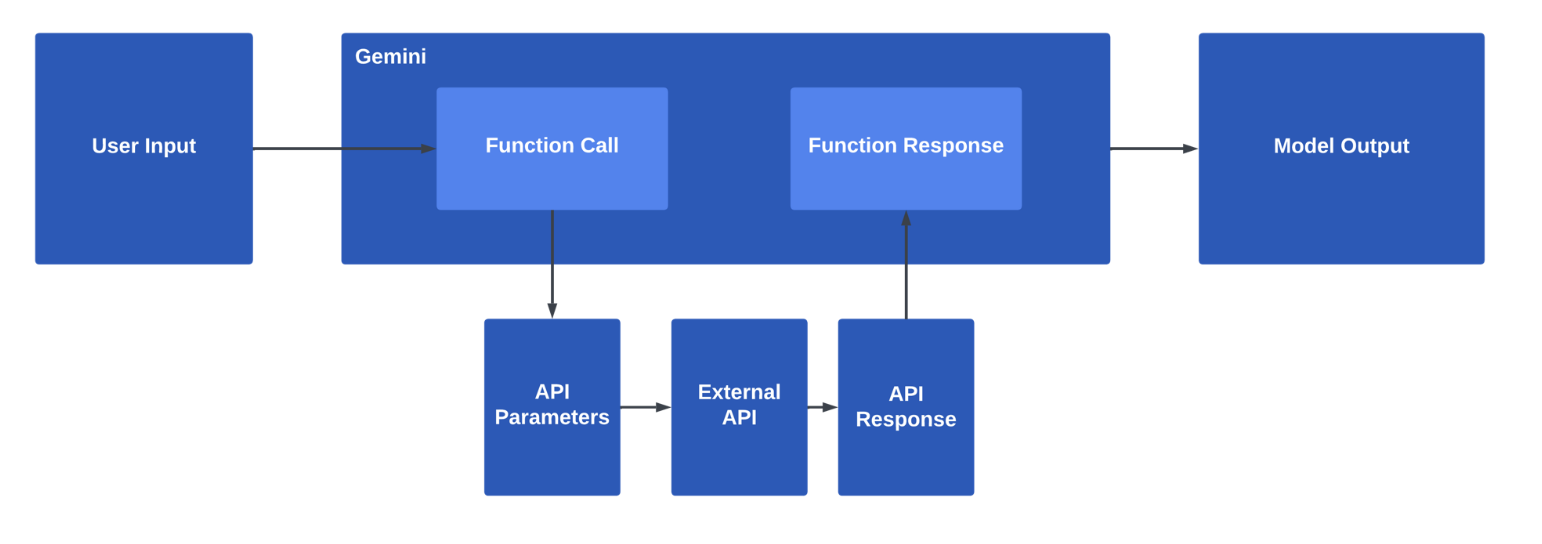

### User input to Gemini API
The prompt from the user is sent to the Gemini API, and in that API call to the Gemini model, the developer has defined one or more function declarations within a tool so that the Gemini model knows which functions it can call and how to call them.

```
User Input -> Gemini API -> Function Call
```

### The Gemini API returns a Function Call
Based on the content of the user input and prompt, Gemini will return a Function Call response with structured data that includes the name of the function to call and the corresponding parameters to use.


```
Gemini API -> Function Call
```

### Make an API request
Then, you'll use the function name and parameters to make an API request to retrieve information from an external system or API. This API request and response is implemented by the developer in the application code and happens outside of the scope of the Gemini API and SDK. For example, you might use the requests library in Python to call a REST API and receive a JSON response. Or you can call the function using your preferred approach and client library.

```
API Parameters -> External API -> API Response
```

### Return the API Response to Gemini
Finally, you'll pass the API response back to the Gemini model so that it can generate a response to the end-user's initial prompt or invoke another Function Call response if the Gemini model determines that it needs additional information.

```
API Response -> Function Response -> Model Output
```

## 6. Choose your API
Now that you understand the overall flow and specific steps in function calling, you'll build a generative AI pipeline to fetch the latest currency exchange rates. First, we'll need to select which API that we want to use as a source of information.

For our currency exchange app, we'll use the REST API at https://www.frankfurter.app/ to fetch the latest information about global exchange rates.

To interact with this REST API, we might make a REST API call with requests in Python as:

In [9]:
import requests
url = "https://api.frankfurter.app/latest"
response = requests.get(url)
response.text

'{"amount":1.0,"base":"EUR","date":"2025-05-15","rates":{"AUD":1.7457,"BGN":1.9558,"BRL":6.2954,"CAD":1.5645,"CHF":0.9377,"CNY":8.0661,"CZK":24.922,"DKK":7.4601,"GBP":0.8424,"HKD":8.7325,"HUF":403.38,"IDR":18484,"ILS":3.9607,"INR":95.65,"ISK":144.7,"JPY":163.3,"KRW":1563.75,"MXN":21.636,"MYR":4.7905,"NOK":11.65,"NZD":1.9037,"PHP":62.433,"PLN":4.2423,"RON":5.1051,"SEK":10.8875,"SGD":1.4528,"THB":37.263,"TRY":43.279,"USD":1.1185,"ZAR":20.221}}'

which returns a response similar to:
```
{
  "amount": 1,
  "base": "EUR",
  "date": "2023-12-20",
  "rates": {
    "AUD": 1.6186, "BGN": 1.9558, "BRL": 5.3287,
    "CAD": 1.4609, "CHF": 0.946, "CNY": 7.8121,
    "CZK": 24.538, "DKK": 7.4565, "GBP": 0.86555,
    "HKD": 8.5439, "HUF": 385.23, "IDR": 16994,
    "ILS": 3.9983, "INR": 91.06, "ISK": 150.3,
    "JPY": 157.12, "KRW": 1425.62, "MXN": 18.6867,
    "MYR": 5.0977, "NOK": 11.2895, "NZD": 1.7421,
    "PHP": 60.991, "PLN": 4.3413, "RON": 4.9699,
    "SEK": 11.129, "SGD": 1.4562, "THB": 38.252,
    "TRY": 31.883, "USD": 1.0944, "ZAR": 20.111
  }
}
```

Because function calling in Gemini does not actually make the external API call for you, there are no such restrictions on what type of API that you use! You could use a Cloud Run Service, a Cloud Function, an API request to a Google Cloud service, or any external REST API.

## 7. Define a function and tool
Now that you've selected a REST API to use, we can now define an API specification and register the function in a tool.

Ensure that you've installed the latest version of the Vertex AI SDK for Python.

Then, import the necessary modules from the Python SDK and initialize the Gemini model:

In [42]:
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    Part,
    Tool,
)

model = GenerativeModel("gemini-2.0-flash-001")

Referring back to the REST API at https://api.frankfurter.app/, we can see that it accepts the following input parameters:


|Parameter | Type   | Description             |
|-----|--------|------------------------------------|
|from      | String | Currency to convert from|
|to        | String | Currency to convert to. |
|date | String | Date to fetch the exchange rate for|




Using these parameters, a partial OpenAPI specification for this REST API in YAML format looks like:

```
openapi: 3.0.0
info:
  title: Frankfurter Exchange Rate API
  description: This API provides current and historical exchange rates
  version: 1.0.0
servers:
  - url: https://api.frankfurter.app
paths:
  /{date}:
    get:
      summary: Get the latest currency exchange rates.
      parameters:
        - name: date
          in: path
          description: Get currency rates for a specific date or 'latest' if a date is not specified
          required: true
          schema:
            type: string
        - name: from
          in: query
          description: The currency to convert from.
          required: true
          schema:
            type: string
        - name: to
          in: query
          description: The currency to convert to.
          schema:
            type: string
```

Now, let's register this as a `FunctionDeclaration` using the Python SDK for Gemini:

In [52]:
get_exchange_rate_func = FunctionDeclaration(
    name="get_exchange_rate",
    description="Get the exchange rate for currencies between countries",
    parameters={
    "type": "OBJECT",
    "properties": {
        "currency_date": {
            "type": "STRING",
            "description": "A date that must always be in YYYY-MM-DD format or the value 'latest' if a time period is not specified"
        },
        "currency_from": {
            "type": "OBJECT",
            "description": "The currency to convert from in ISO 4217 format"
        },
        "currency_to": {
            "type": "OBJECT",
            "description": "The currency to convert to in ISO 4217 format"
        }
    },
         "required": [
            "currency_from",
            "currency_date",
      ]
  },
)

Be sure to use as much detail as possible in the function and parameter descriptions since the generative model will use this information to determine which function to select and how to fill the parameters in the function call.

Finally, you'll define a `Tool` that includes the function declaration:

In [53]:
exchange_rate_tool = Tool(
    function_declarations=[get_exchange_rate_func],
)

Here, you're using one function declaration within a tool, but note that you can register one or more function declarations in a tool, and the model will select the appropriate function to use at runtime. Refer to the documentation on Function Calling in the Gemini API for more details on the FunctionDeclaration, Tool, and related classes in the Gemini SDK for Python.

You've completed the configuration of your function and tool definitions. In the next section, we'll call the generative model with this tool and get back a function call that we can use to call the REST API.

## 8. Generate a function call
Now you can prompt the generative model and include the tool that you defined:

In [61]:
prompt = """What is the exchange rate from Australian dollars to Swedish krona on 30 April 2025?
How much is 500 Australian dollars worth in Swedish krona?"""

response = model.generate_content(
    prompt,
    tools=[exchange_rate_tool],
)
response

candidates {
  content {
    role: "model"
    parts {
      function_call {
        name: "get_exchange_rate"
        args {
          fields {
            key: "currency_to"
            value {
              string_value: "SEK"
            }
          }
          fields {
            key: "currency_from"
            value {
              string_value: "AUD"
            }
          }
          fields {
            key: "currency_date"
            value {
              string_value: "2025-04-30"
            }
          }
        }
      }
    }
  }
  finish_reason: STOP
  avg_logprobs: -0.0014120472165254445
}
usage_metadata {
  prompt_token_count: 123
  candidates_token_count: 26
  total_token_count: 149
  prompt_tokens_details {
    modality: TEXT
    token_count: 123
  }
  candidates_tokens_details {
    modality: TEXT
    token_count: 26
  }
}
model_version: "gemini-2.0-flash-001"
create_time {
  seconds: 1747402641
  nanos: 163580000
}
response_id: "kT8naPz9Cc-t698Pr7mbyAI"

Let's take a look at the response object:
```
print(response.candidates[0].content)

role: "model"
parts {
  function_call {
    name: "get_exchange_rate"
    args {
      fields {
        key: "currency_to"
        value {
          string_value: "SEK"
        }
      }
      fields {
        key: "currency_from"
        value {
          string_value: "AUD"
        }
      }
      fields {
        key: "currency_date"
        value {
          string_value: "latest"
        }
      }
    }
  }
}
```

It looks like the model selected the one available function and returned a function call for the `get_exchange_rate` function along with the parameters. And the parameters are in the correct format that we wanted. Hooray for getting structured responses from generative models!

In the next section, you'll use the information in the response to make an API request.

## 9. Make an API request
Recall that function calling in Gemini does not actually make the external API call for you. Rather, you are free to use any language, library, or framework that you'd like!

Here you'll use the requests library in Python to call the exchange rate REST API.

Let's unpack the response into a Python dictionary:

In [62]:
params = {}
for key, value in response.candidates[0].content.parts[0].function_call.args.items():
    params[key[9:]] = value
print(params)

{'from': 'AUD', 'date': '2025-04-30', 'to': 'SEK'}


Now we can call `requests` or any other method:

In [63]:
import requests
url = f"https://api.frankfurter.app/{params['date']}"
api_response = requests.get(url, params=params)
print(api_response.text)

{"amount":1.0,"base":"AUD","date":"2025-04-30","rates":{"SEK":6.1645}}


And we have our response from the REST API, with the latest exchange rate information from today. In the next section, we'll pass this information back to the model so that it can generate a relevant response for the user.

## 10. Generate a response
Finally, let's generate a response for the user by passing back the function response to the model in the next conversation turn:

In [64]:
response = model.generate_content(
    [
    Content(role="user", parts=[
        Part.from_text(prompt + """Give your answer in steps with lots of detail
            and context, including the exchange rate and date."""),
    ]),
    Content(role="function", parts=[
        Part.from_dict({
            "function_call": {
                "name": "get_exchange_rate",
            }
        })
    ]),
    Content(role="function", parts=[
        Part.from_function_response(
            name="get_exchange_rate",
            response={
                "content": api_response.text,
            }
        )
    ]),
    ],
    tools=[exchange_rate_tool],
)


print(response.candidates[0].content.parts[0].text)

On 2025-04-30, the exchange rate from Australian dollars to Swedish krona is 1 AUD = 6.1645 SEK.

Therefore, 500 Australian dollars is worth 500 * 6.1645 = 3082.25 Swedish krona.



Once we pass the function response back to the model, it will respond to the user's prompt along with relevant information from the API response.

## 11. View the full code example
At this point, you could put your Python code in a backend API using a Cloud Run service, a Cloud Function, or another Cloud service and deploy a frontend app that uses this backend API to perform model queries and API calls.

Here's the full code example for our final solution:

In [ ]:
import requests
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerativeModel,
    Part,
    Tool,
)

model = GenerativeModel("gemini-1.5-pro-001")

get_exchange_rate_func = FunctionDeclaration(
    name="get_exchange_rate",
    description="Get the exchange rate for currencies between countries",
    parameters={
    "type": "object",
    "properties": {
        "currency_date": {
            "type": "string",
            "description": "A date that must always be in YYYY-MM-DD format or the value 'latest' if a time period is not specified"
        },
        "currency_from": {
            "type": "string",
            "description": "The currency to convert from in ISO 4217 format"
        },
        "currency_to": {
            "type": "string",
            "description": "The currency to convert to in ISO 4217 format"
        }
    },
         "required": [
            "currency_from",
            "currency_date",
      ]
  },
)

exchange_rate_tool = Tool(
    function_declarations=[get_exchange_rate_func],
)

prompt = """What is the exchange rate from Australian dollars to Swedish krona?
How much is 500 Australian dollars worth in Swedish krona?"""

response = model.generate_content(
    prompt,
    tools=[exchange_rate_tool],
)

response.candidates[0].content

params = {}
for key, value in response.candidates[0].content.parts[0].function_call.args.items():
    params[key[9:]] = value
params

import requests
url = f"https://api.frankfurter.app/{params['date']}"
api_response = requests.get(url, params=params)
api_response.text

response = model.generate_content(
    [
    Content(role="user", parts=[
        Part.from_text(prompt + """Give your answer in steps with lots of detail
            and context, including the exchange rate and date."""),
    ]),
    Content(role="function", parts=[
        Part.from_dict({
            "function_call": {
                "name": "get_exchange_rate",
            }
        })
    ]),
    Content(role="function", parts=[
        Part.from_function_response(
            name="get_exchange_rate",
            response={
                "content": api_response.text,
            }
        )
    ]),
    ],
    tools=[exchange_rate_tool],
)


response.candidates[0].content.parts[0].text

In this implementation, we used two requests to the generative model: one request to generate a function call and another request to return the function response. Note that this is only one method of handling function calls and function responses with Gemini. You can also make additional function calls to get more information for your query, or use function calling with chat and asynchronous methods.

For additional code samples, refer to the [sample notebook for function calling in Gemini](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/function-calling/intro_function_calling.ipynb).



## 12. Congratulations
Using function calling in Gemini, you've successfully built a generative AI pipeline that uses with the Vertex AI Gemini API and Python! Users can ask about exchange rates, and the system will fetch the latest data from an external API and respond with an answer.

Given a prompt from an end-user, function calling in Gemini takes care of selecting the appropriate function, extracting parameters from the prompt, and returning a structured data object for you to make an external API call.

The design of function calling in Gemini is intended to give you the best of both worlds for deterministically extracting parameters, while leaving the summarization and content creation to the generative model. Feel free to try out other APIs and prompts in your pipeline and explore the other functionality available related to Vertex AI Gemini API.